A notebook to train and test an ImageNet-pretrained VGG-16 neural network. 

This notebook assumes that the chips for each class are stored in a separate subdirectory named after the corresponding class.

tif, png, and jpg formats are supported. 

In [1]:
import os
import cv2
import h5py
import glob
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from os.path import join, exists
from random import shuffle, choice
from shutil import copyfile

from keras.models import Model, load_model
from keras.optimizers import SGD
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Flatten, Dropout
from keras.applications.vgg16 import VGG16
from keras import backend
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [2]:
chip_directory = 'formatted-chips'
train_directory = 'train'            # training data directory
test_directory = 'test'              # test data directory
model_directory = 'models'           # directory where models are stored
chip_classes = ['Boat', 'Other']     # class names
train_percent = [90, 90]             # percentage of chips from each class to be used for training; the remainder are used for testing 
validate_percent = 15                # percentage of chips from the training set to be used for validation   
no_init_epochs = 2                   # first train final dense layer and softmax layer for this number of epochs ...
min_layer = 15                       # then train all layers beyond this index ...
no_epochs = 20                       # for this number of epochs 
learning_rate = 0.0001               # learning rate 
side = 224                           # chip side length in pixels (square chips assumed)

# model name
model_file = join(model_directory, 'model-epochs-{}-lr-{}-8-23-2017.h5'.format(no_epochs, learning_rate))

Make directories and distribute chips.

In [3]:
if not exists(model_directory):
    os.makedirs(model_directory)

for directory in [train_directory, test_directory]:
    if not exists(directory):
        os.makedirs(directory)
        for class_name in chip_classes:
            os.makedirs(join(directory, class_name))            

In [4]:
train_size, test_size = 0, 0

for i, class_name in enumerate(chip_classes):
    chips = glob.glob(join(chip_directory, class_name, '*'))  
    print len(chips)
    shuffle(chips)  # shuffle the chips to introduce randomness (could be necessary if chips are ordered in some way)
    train_size_class = int(train_percent[i]/100.0*len(chips))
    test_size_class = len(chips) - train_size_class
    train_size += train_size_class
    test_size += test_size_class
    print 'Class: {}, train/test: {} {}'.format(class_name, 
                                                train_size_class, 
                                                test_size_class)
    for j, chip in enumerate(chips):
        if j < train_size_class:
            copyfile(chip, join(train_directory, class_name, chip.split('/')[-1]))
        else:
            copyfile(chip, join(test_directory, class_name, chip.split('/')[-1]))

1636
Class: Boat, train/test: 1472 164
5277
Class: Other, train/test: 4749 528


Plot a few chips.

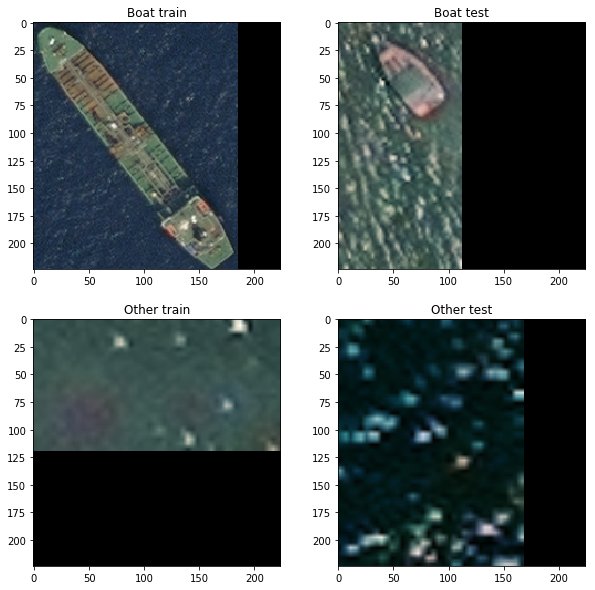

In [5]:
def plot(plt, chip):
    'Generic plot function that uses opencv'
    plt.imshow(cv2.cvtColor(cv2.imread(chip).astype('uint8'), cv2.COLOR_BGR2RGB))    

plt.figure(figsize=(10, 10))

for i, class_name in enumerate(chip_classes):
    train_chip = choice(glob.glob(join(train_directory, class_name, '*')) )
    plt.subplot(len(chip_classes), 2, 2*i+1)
    plt.title('{} {}'.format(class_name, 'train'))
    plot(plt, train_chip)
    test_chip = choice(glob.glob(join(test_directory, class_name, '*')) )
    plt.subplot(len(chip_classes), 2, 2*i+2)
    plt.title('{} {}'.format(class_name, 'test'))
    plot(plt, test_chip)

We're almost ready to train. 

We'll first implement a generic generator function that yields a batch of numpy arrays X and the corresponding one-hot vectors Y.

In [6]:
def preprocess(img):
    '''
    Subtract a given value from each band. 
    This is required due to the fact that VGG-16 is pretrained on ImageNet.  
    img is a 3d array where dimensions 1-3 correspond to the B, G, R bands.
    '''
    
    img[:,:,0] -= 103.939
    img[:,:,1] -= 116.779
    img[:,:,2] -= 123.68
    
    return img

def get_batch(data_dir, batch_size=5000, return_ids=False):
    '''
    data_dir: Includes one subdirectory per class, named after that class.
    batch_size: The size of the batch.
    return_ids: If true, return the chip names.
    '''
    
    # Get class names
    class_names = [sub_dir for sub_dir in os.listdir(data_dir)]
 
    # Get a list of all chips and shuffle it to introduce randomness
    chips = glob.glob(join(data_dir, '*', '*'))
    np.random.shuffle(chips)

    for i in range(0, len(chips), batch_size):
        
        chip_batch = chips[i:i+batch_size]
        
        X = np.array([preprocess(cv2.imread(chip).astype('float32')) for chip in chip_batch])
        y, ids = zip(*[[class_names.index(chip.split('/')[-2]), chip.split('/')[-1][:-4]] for chip in chip_batch])
        Y = to_categorical(y, num_classes=len(class_names))
        
        if return_ids:
            yield X, Y, ids
        else:
            yield X, Y

Load an existing model or a base model with ImageNet weights.

In [7]:
model_file = ''

if os.path.exists(model_file):
    backend.clear_session()
    model = load_model(model_file)
else:
    print 'Creating new model'
    model = VGG16(include_top=False, weights='imagenet', input_shape=(side, side, 3))
    x = Flatten()(model.layers[-1].output)        # remember that the final fully connected layers have not been included
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    preds = Dense(len(chip_classes), activation='softmax')(x)
    model = Model(inputs=model.input, outputs=preds)

sgd = SGD(lr=learning_rate, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

Creating new model


First train the last dense layer and the softmax layer; this can be thought of as priming the pre-trained network.
If the size of the training set is larger than 5000, train in batches.

In [12]:
batch_size = 2800
no_batches = train_size/batch_size + 1

# Freeze all layers up to 19
for layer in model.layers[:19]:
    layer.trainable = False

old_validation_loss = 1      
    
for epoch in range(no_init_epochs):

    batch = get_batch(data_dir=train_directory, batch_size=batch_size)
    
    for i in range(no_batches):

        print 'Initialization epoch {}: Batch {} of {}'.format(epoch + 1, i + 1, no_batches)         
        X, Y = next(batch)
        val_size = validate_percent*len(X)/100
        val_X, val_Y = X[:val_size], Y[:val_size]
        train_X, train_Y = X[val_size:], Y[val_size:]
        model.fit(train_X, train_Y, batch_size=32, validation_data=(val_X, val_Y), epochs=1)
        new_validation_loss, new_validation_accuracy = model.evaluate(val_X, val_Y)
        if epoch == 0 or new_validation_loss < old_validation_loss:
            model.save(model_file)
            old_validation_loss = new_validation_loss

Initialization epoch 1: Batch 1 of 3
Train on 2380 samples, validate on 420 samples
Epoch 1/1
420/420 [==============================] - 6s     
Initialization epoch 1: Batch 2 of 3
Train on 2380 samples, validate on 420 samples
Epoch 1/1
420/420 [==============================] - 6s     
Initialization epoch 1: Batch 3 of 3
Train on 528 samples, validate on 93 samples
Epoch 1/1
93/93 [==============================] - 1s     
Initialization epoch 2: Batch 1 of 3
Train on 2380 samples, validate on 420 samples
Epoch 1/1
420/420 [==============================] - 6s     
Initialization epoch 2: Batch 2 of 3
Train on 2380 samples, validate on 420 samples
Epoch 1/1
420/420 [==============================] - 6s     
Initialization epoch 2: Batch 3 of 3
Train on 528 samples, validate on 93 samples
Epoch 1/1
93/93 [==============================] - 1s     


Now train the last three convolutional layers along with the last dense layer and the softmax layer.

In [13]:
model = load_model(model_file)

for layer in model.layers[:15]:
    layer.trainable = False
for layer in model.layers[15:]:
    layer.trainable = True
    
old_validation_loss, old_validation_accuracy = 1, 0  
    
for epoch in range(no_epochs):
    
    batch = get_batch(data_dir=train_directory, batch_size=batch_size)
    
    for i in range(no_batches):

        print 'Epoch {}: Batch {} of {}'.format(epoch + 1, i + 1, no_batches)        
        X, Y = next(batch)
        val_size = validate_percent*len(X)/100
        val_X, val_Y = X[:val_size], Y[:val_size]
        train_X, train_Y = X[val_size:], Y[val_size:]
        model.fit(train_X, train_Y, batch_size=32, validation_data=(val_X, val_Y), epochs=1)
        new_validation_loss, new_validation_accuracy = model.evaluate(val_X, val_Y)
        if epoch == 0 or new_validation_loss < old_validation_loss:
            model.save(model_file)
            old_validation_loss, old_validation_accuracy = new_validation_loss, new_validation_accuracy
            
print 'Best val loss = {}, best val accuracy = {}'.format(old_validation_loss, old_validation_accuracy)            

/home/ubuntu/miniconda2/lib/python2.7/site-packages/keras/models.py:281: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


Epoch 1: Batch 1 of 3
Train on 2380 samples, validate on 420 samples
Epoch 1/1
420/420 [==============================] - 6s     
Epoch 1: Batch 2 of 3
Train on 2380 samples, validate on 420 samples
Epoch 1/1
420/420 [==============================] - 6s     
Epoch 1: Batch 3 of 3
Train on 528 samples, validate on 93 samples
Epoch 1/1
93/93 [==============================] - 1s     
Epoch 2: Batch 1 of 3
Train on 2380 samples, validate on 420 samples
Epoch 1/1
420/420 [==============================] - 6s     
Epoch 2: Batch 2 of 3
Train on 2380 samples, validate on 420 samples
Epoch 1/1
420/420 [==============================] - 6s     
Epoch 2: Batch 3 of 3
Train on 528 samples, validate on 93 samples
Epoch 1/1
93/93 [==============================] - 1s     
Epoch 3: Batch 1 of 3
Train on 2380 samples, validate on 420 samples
Epoch 1/1
420/420 [==============================] - 6s     
Epoch 3: Batch 2 of 3
Train on 2380 samples, validate on 420 samples
Epoch 1/1
420/420 [==========

Evaluate accuracy on the test set.

In [14]:
model = load_model(model_file)
test_batch = get_batch(data_dir=test_directory, batch_size=test_size, return_ids = True)
test_X, test_Y, test_ids = next(test_batch)
test_ids = np.array(test_ids)

# from categorical to class indices
true_labels = np.array([chip_classes[np.argmax(row)] for row in test_Y])

# predict function returns a probability distribution on every chip in the test set
probability_distributions = model.predict(test_X)
predictions = np.array([chip_classes[np.argmax(distribution)] for distribution in probability_distributions])

In [16]:
cm = confusion_matrix(predictions, true_labels)
precision = float(cm[0, 0])/(cm[0, 0] + cm[0, 1])
recall = float(cm[0, 0])/(cm[0, 0] + cm[1, 0])
accuracy = float(cm[0, 0] + cm[1, 1])/(np.sum(cm))
print 'Confusion matrix: {}'.format(cm)
print 'Precision: {}'.format(precision)
print 'Recall: {}'.format(recall)
print 'F-score: {}'.format(2/(1/precision + 1/recall))
print 'Accuracy: {}'.format(accuracy)

# record stats
with open(join(model_directory, 'model_stats.txt'), 'a') as f:
    f.write('''Model {}: 
               val loss = {}, 
               val accuracy = {}, 
               confusion matrix = {}, 
               precision = {}, 
               recall = {}, 
               F-score = {}, 
               Accuracy = {} \n'''.format(model_file, 
                                          old_validation_loss, 
                                          old_validation_accuracy,
                                          cm,
                                          precision,
                                          recall,
                                          2/(1/precision + 1/recall),
                                          accuracy))

Confusion matrix: [[148   8]
 [ 16 520]]
Precision: 0.948717948718
Recall: 0.90243902439
F-score: 0.925
Accuracy: 0.965317919075


Use the model to classify all the chips and identify ids of chips which were misclassified. This is useful in order to clean up the initial set from mislabeled chips. 

In [ ]:
batch_size = 2800
no_batches = (train_size + test_size)/batch_size + 1

eval_batch = get_batch(data_dir=chip_directory, batch_size=batch_size, return_ids = True)

errors_01, errors_10 = [], []

for i in range(no_batches):

    print 'Batch {} of {}'.format(i+1, no_batches)
    
    X, Y, ids = next(eval_batch)
    ids = np.array(ids)

    # from categorical to class indices
    true_labels = np.array([chip_classes[np.argmax(row)] for row in Y])

    # predict function returns a probability distribution on every chip in the test set
    probability_distributions = model.predict(X)
    predictions = np.array([chip_classes[np.argmax(distribution)] for distribution in probability_distributions])
    
    # 0->1 errors
    errors_01.extend(ids[(true_labels == chip_classes[0]) & (predictions != true_labels)])

    # 1->0 errors
    errors_10.extend(ids[(true_labels == chip_classes[1]) & (predictions != true_labels)])
     

In [ ]:
print '{} -> {} errors'.format(chip_classes[0], chip_classes[1])
for ind in np.sort(map(int, errors_01)):
    print ind

print '{} -> {} errors'.format(chip_classes[1], chip_classes[0])
for ind in np.sort(map(int, errors_10)):
    print ind